# Object Detection and Audio Transcription Using Whisper and YOLOv5 With German

This notebook demonstrates how to perform object detection in images and audio transcription using the Whisper model and the YOLOv5 model using German language. We will upload an audio file in German and an image file, and the system will transcribe the audio to text and detect objects in the image based on the transcribed text.

----




## Setup
### Install Required Libraries

Make sure you have the necessary libraries installed in your Google Colab environment.

```python
# Install necessary packages
!pip install torch torchvision torchaudio
!pip install git+https://github.com/openai/whisper.git
!pip install opencv-python-headless
!pip install -U -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt
```

In [ ]:
!pip install torch torchvision torchaudio
!pip install git+https://github.com/openai/whisper.git
!pip install opencv-python-headless

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-r_ixgyil
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-r_ixgyil
  Resolved https://github.com/openai/whisper.git to commit 25639fc17ddc013d56c594bfbf7644f2185fad84
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.4 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803321 sha256=80c589f1e1c10d756486557d183982e4ef525ad6f889fa2f304e8bc1d9374dfe
  Stored in directory: /tmp/pip-ephem-wheel-cache-7bfips9o/wheels/8b/6c/d0/622666868c179f156cf595c8b6f06f88bc5d80c4b31dccaa03
Successfully built openai-whisper


### Import Libraries

We will import the required libraries.

In [ ]:
import numpy as np
import torch
import whisper
import cv2
import os
import random
import string
import matplotlib.pyplot as plt
import numpy as np

## Load Models

### Load Whisper Model


We will load the Whisper model for audio transcription.


In [ ]:
# Load Whisper model
whisper_model = whisper.load_model("small")

100%|███████████████████████████████████████| 461M/461M [00:07<00:00, 63.8MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

### Load YOLOv5 Model

Next, we load the YOLOv5 model for object detection.

In [ ]:
try:
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
    print("YOLOv5 loaded successfully.")
except Exception as e:
    print(f"Error loading YOLOv5: {e}")

/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 151.1 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 5.9s, installed 1 package: ['gitpython>=3.1.30']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2024-10-12 Python-3.10.12 torch-2.4.1+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 123MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


YOLOv5 loaded successfully.


## Helper Functions

### Generate Unique Color Function

This function generates a distinct color for each detected object.

In [ ]:
def generate_unique_color(existing_colors):
    """Generates a distinct color by selecting from a set of predefined, widely separated colors."""
    distinct_colors = [
        (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255),
        (0, 255, 255), (128, 0, 128), (128, 128, 0), (0, 128, 128), (255, 165, 0)
    ]

    random.shuffle(distinct_colors)

    for color in distinct_colors:
        if color not in existing_colors:
            return color

    # Fallback to random if we run out of distinct colors (unlikely in typical object detection)
    return tuple(random.randint(0, 255) for _ in range(3))

### Object Ids for YOLO

In [ ]:
german_to_id = {
    0: "Person",
    1: "Fahrrad",
    2: "Auto",
    3: "Motorrad",
    4: "Flugzeug",
    5: "Bus",
    6: "Zug",
    7: "Lastwagen",
    8: "Boot",
    9: "Ampel",
    10: "Hydrant",
    11: "Stoppschild",
    12: "Parkuhr",
    13: "Bank",
    14: "Vogel",
    15: "Katze",
    16: "Hund",
    17: "Pferd",
    18: "Schaf",
    19: "Kuh",
    20: "Elefant",
    21: "Bär",
    22: "Zebra",
    23: "Giraffe",
    24: "Rucksack",
    25: "Regenschirm",
    26: "Handtasche",
    27: "Krawatte",
    28: "Koffer",
    29: "Frisbee",
    30: "Ski",
    31: "Snowboard",
    32: "Sportball",
    33: "Drachen",
    34: "Baseballschläger",
    35: "Baseballhandschuh",
    36: "Skateboard",
    37: "Surfbretter",
    38: "Tennisschläger",
    39: "Flasche",
    40: "Weinglas",
    41: "Tasse",
    42: "Gabel",
    43: "Messer",
    44: "Löffel",
    45: "Schüssel",
    46: "Banane",
    47: "Apfel",
    48: "Sandwich",
    49: "Orange",
    50: "Brokkoli",
    51: "Karotte",
    52: "Hotdog",
    53: "Pizza",
    54: "Donut",
    55: "Kuchen",
    56: "Stuhl",
    57: "Sofa",
    58: "Blumentopf",
    59: "Bett",
    60: "Esstisch",
    61: "Toilette",
    62: "Fernseher",
    63: "Laptop",
    64: "Maus",
    65: "Fernbedienung",
    66: "Tastatur",
    67: "Handy",
    68: "Mikrowelle",
    69: "Ofen",
    70: "Toaster",
    71: "Spüle",
    72: "Kühlschrank",
    73: "Buch",
    74: "Uhr",
    75: "Vase",
    76: "Schere",
    77: "Teddybär",
    78: "Haartrockner",
    79: "Zahnbürste"
}

### Detect Objects Function

This function handles the object detection process in an image based on the transcribed audio text.

In [ ]:
def detect_objects(image_path, german_text):
    # Load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Perform detection
    with torch.no_grad():
        results = model(img_rgb)

    # Convert results to a Pandas DataFrame
    df = results.pandas().xyxy[0]

    object_ids = []
    detected_objects = []
    confidences = []
    object_colors = {}  # Dictionary to hold colors for each detected label

    german_text_cleaned = german_text.translate(str.maketrans('', '', string.punctuation))

    # Identify object IDs based on German text
    for word in german_text_cleaned.split():
        for key, value in german_to_id.items():
            if word.lower() == value.lower():
                object_ids.append(key)

    # Iterate over detected objects
    for _, row in df.iterrows():
        if int(row['class']) in object_ids:
            x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
            label = german_to_id[int(row['class'])]
            confidence = row['confidence']

            # Check if the color for the label has already been assigned
            if label not in object_colors:
                # Assign a unique color to the label
                object_colors[label] = generate_unique_color(object_colors.values())

            color = object_colors[label]  # Use the assigned color for drawing

            # Draw the rectangle and label with the matching color
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, f"{label}: {confidence:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            detected_objects.append(label)
            confidences.append(confidence)

    # Save the detected image
    detected_image_path = "detected_" + os.path.basename(image_path)
    cv2.imwrite(detected_image_path, img)

    # Serialize the colors to JSON-friendly format (tuple to list)
    object_colors_serialized = {label: list(color) for label, color in object_colors.items()}
    return detected_image_path, detected_objects, confidences, object_colors_serialized

## Transcribing Audio

### Function to Transcribe Audio

This function processes the uploaded audio file and returns the transcribed text and overall confidence score.

In [ ]:
def transcribe_audio(audio_filepath):
    transcript = ""
    overall_confidence = 0

    try:
        # Audio transcription
        result = whisper_model.transcribe(audio_filepath, language='de')
        transcript = result['text']
        total_confidence = sum([1 - seg['no_speech_prob'] for seg in result['segments']])
        overall_confidence = total_confidence / len(result['segments']) if result['segments'] else 0
    except Exception as e:
        print(f"Failed to process the audio file: {str(e)}")
    finally:
        os.remove(audio_filepath)

    return transcript, overall_confidence

## Main Process Function

This function integrates the audio transcription and object detection.

In [ ]:
def process_files(audio_file_path, image_file_path):
    # Transcribe the audio file
    transcript, overall_confidence = transcribe_audio(audio_file_path)

    # Detect objects in the image
    detected_img_path, objects, obj_accuracy, object_colors = detect_objects(image_file_path, transcript)

    response = {
        "transcript": transcript,
        "overall_average_confidence": overall_confidence,
        "image_path": detected_img_path,
        "object_detection": objects,
        "object_confidences": obj_accuracy,
        "object_colors": object_colors
    }

    return response

## Display Detected Image

### Function to Show Detected Image

This function displays the processed image using Matplotlib.

In [ ]:
def display_detected_image(image_path):
    """Display the detected image."""
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axes
    plt.show()


## Usage Example

### Uploading Files

To test the functionality, upload your audio and image files.

In [ ]:
# Example paths for uploaded files
audio_file_path = "/content/6.wav"
image_file_path = "/content/street.jpeg"

# Process the uploaded files
response = process_files(audio_file_path, image_file_path)


# Print the transcription and object detection results
print("Transcription:", response["transcript"])
print("Overall Average Confidence:", response["overall_average_confidence"])
print("Detected Objects:", response["object_detection"])
print("Object Confidences:", response["object_confidences"])

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Transcription:  Markieren Sie bitte das Person, das Auto und die Straße.
Overall Average Confidence: 0.947263952344656
Detected Objects: ['Person', 'Auto', 'Auto', 'Auto', 'Auto']
Object Confidences: [0.9233360290527344, 0.8531723022460938, 0.7288002967834473, 0.4638911485671997, 0.4148244559764862]


### Display Image


array([[[ 11,  11,  11],
        [ 13,  13,  13],
        [ 15,  15,  15],
        ...,
        [162, 154, 151],
        [157, 148, 143],
        [151, 142, 137]],

       [[  5,   5,   5],
        [  3,   3,   3],
        [  3,   3,   3],
        ...,
        [159, 151, 148],
        [156, 147, 142],
        [152, 143, 138]],

       [[ 11,  11,  11],
        [  4,   4,   4],
        [  0,   0,   0],
        ...,
        [154, 146, 143],
        [153, 144, 139],
        [152, 143, 138]],

       ...,

       [[125, 127, 126],
        [124, 126, 125],
        [123, 125, 124],
        ...,
        [170, 165, 162],
        [170, 165, 162],
        [170, 165, 162]],

       [[122, 124, 123],
        [122, 124, 123],
        [122, 124, 123],
        ...,
        [169, 161, 159],
        [167, 162, 159],
        [167, 162, 159]],

       [[119, 121, 120],
        [120, 122, 121],
        [120, 122, 121],
        ...,
        [167, 159, 157],
        [165, 160, 157],
        [165, 160, 157]]], dtype=uint8)
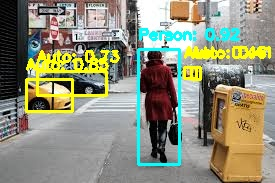

In [ ]:
# Read Image
img = cv2.imread(response["image_path"])
# Convert it into RGP
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_rgb

# **Real-Time Audio Transcription with Flask and Colab**

This notebook demonstrates how to capture audio, send it to a server in 2-second chunks, and receive real-time transcriptions. Since Colab does not have direct access to your microphone, audio needs to be recorded locally, uploaded, and sent in chunks for transcription.

## **Step 1: Install Necessary Libraries**
We'll need the following libraries:
- `requests`: For sending audio data to the server.
- `io` and `wave`: To handle the audio file conversions.

```python
# Install necessary libraries
!pip install requests sounddevice scipy


## **Set Up the Flask Server Locally**
Before we can send audio data for transcription, we need to set up a Flask server that processes the audio data and returns the transcription.

**Instructions:**
1. Run the Flask server on your local machine (or host it on a cloud platform like Heroku).
2. The server will accept audio data in 2-second chunks, process it, and return a transcription using a speech recognition engine.

### Flask Server Code (To run locally or on a cloud platform):
Save this code in a Python file (e.g., `app.py`) and run it on your local machine.


In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import speech_recognition as sr
import wave
import io

app = Flask(__name__)
CORS(app)
#assume you have the model whisper as 'whisper_model'


@app.route("/transcribe_chunk", methods=["POST"])
def transcribe_chunk():
    audio_file = request.files.get('audio')

    if audio_file is None:
        return jsonify({'error': 'No audio file provided'}), 400

    try:
        audio_path = os.path.join(UPLOAD_FOLDER, "temp_audio_chunk.wav")
        audio_file.save(audio_path)

        segments = whisper_model.transcribe(audio_path, language='de')
        transcription = segments['text']

        os.remove(audio_path)  # Clean up the temporary file

        return jsonify({'transcription': transcription}), 200
    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == "__main__":
    app.run(debug=True)


### To run the server:
1. Install Flask and Flask-CORS:
   ```bash
   pip install flask flask-cors
   ```

2. Run the Flask server:
   ```bash
   python app.py
   ```

   This will start a server locally at `http://localhost:5000` and listen for incoming audio chunks.



## **Upload Audio Chunks to the Colab Notebook**

In this section, we will simulate real-time audio chunk uploads. Since Colab cannot access your microphone directly, you'll need to record audio locally and upload it.

We can process the uploaded file and send 4-second chunks to the Flask server.

In [ ]:
import sounddevice as sd
import numpy as np
import requests
import wave
import io
import threading
import queue
import time

# Configuration
SAMPLE_RATE = 16000  # Sample rate for audio recording
CHUNK_DURATION = 4  # Duration of each chunk in seconds
SERVER_URL = "http://localhost:5000/transcribe_chunk"  # Server URL
SAMPLE_WIDTH = 2  # Bytes per sample (16-bit audio)

# Queue to hold audio chunks to be sent
audio_queue = queue.Queue()

def record_audio_stream(q, chunk_duration, sample_rate):
    """Continuously record audio and place chunks into the queue."""
    chunk_size = int(chunk_duration * sample_rate)
    print("Starting to record audio...")

    def callback(indata, frames, time, status):
        if status:
            print(f"Recording error: {status}")
        # Put the audio data into the queue in chunks
        q.put(indata.copy())

    # Start non-blocking recording
    with sd.InputStream(samplerate=sample_rate, channels=1, dtype='float32', blocksize=chunk_size, callback=callback):
        while True:
            time.sleep(0.1)  # Keep the main thread alive

def save_audio_to_wav(audio_data, sample_rate):
    """Save the recorded audio chunk to a WAV format in memory."""
    byte_io = io.BytesIO()
    with wave.open(byte_io, 'wb') as wav_file:
        wav_file.setnchannels(1)  # Mono
        wav_file.setsampwidth(SAMPLE_WIDTH)  # 16-bit audio
        wav_file.setframerate(sample_rate)
        # Convert from float32 (-1.0 to 1.0) to int16 (-32768 to 32767)
        wav_file.writeframes((audio_data * 32767).astype(np.int16).tobytes())
    byte_io.seek(0)
    return byte_io

def send_audio_chunk_to_server(audio_chunk, sample_rate):
    """Send the audio chunk to the server."""
    wav_io = save_audio_to_wav(audio_chunk, sample_rate)

    try:
        files = {'audio': ('chunk.wav', wav_io, 'audio/wav')}
        response = requests.post(SERVER_URL, files=files)
        if response.ok:
            transcription = response.json().get('transcription', '')
            print(f"Transcription: {transcription}")
        else:
            print(f"Server error: {response.status_code}")
    except Exception as e:
        print(f"Failed to send audio chunk: {str(e)}")

def process_audio_chunks(q):
    """Continuously process audio chunks from the queue and send them to the server."""
    while True:
        audio_chunk = q.get()
        if audio_chunk is None:
            break  # Exit when None is received
        send_audio_chunk_to_server(audio_chunk, SAMPLE_RATE)
        q.task_done()

def main():
    # Start the thread that sends audio chunks to the server
    threading.Thread(target=process_audio_chunks, args=(audio_queue,), daemon=True).start()

    # Start recording audio and queuing chunks
    record_audio_stream(audio_queue, CHUNK_DURATION, SAMPLE_RATE)

if __name__ == "__main__":
    try:
        print("Press Ctrl+C to stop recording...")
        main()
    except KeyboardInterrupt:
        print("Recording stopped.")


### Explanation:
1. **`send_audio_chunk_to_server`**: This function sends each 2-second chunk of audio to the Flask server and receives the transcription.
2. **`simulate_audio_chunk_upload`**: This function simulates how audio is recorded locally in chunks and uploads it to the server.



## **Real-Time Display of Transcriptions**

After sending the chunks to the server, you will receive real-time transcriptions that will be displayed in your notebook.


### Conclusion:

- **Colab Limitations**: Since Colab cannot access your microphone directly, this notebook simulates real-time transcription using pre-recorded audio.
- **Running the Flask Server**: Make sure your Flask server is running locally or on a cloud platform to handle incoming audio chunks.
- **Next Steps**: You can modify the notebook to handle different audio formats and explore more advanced transcription methods using different speech recognition engines.
```

---

### Key Points:

- **Flask Server**: The server must be running either on your local machine or on a remote cloud server.
- **Colab Audio Simulation**: Since Colab cannot directly record audio from your microphone, you should try it on your localhost for the best experiance.
- **Real-Time Chunks**: Each audio chunk (2 seconds long) is sent to the server for transcription in real-time.

By using this structured Colab notebook, you can build a real-time transcription pipeline, splitting audio into manageable chunks and processing them with speech recognition services.


## Conclusion

This notebook demonstrates how to use the Whisper model for audio transcription and YOLOv5 for object detection based on the transcribed audio. You can adapt and extend this code for more complex applications or integrate it into a web application using Flask with additional feature to be used on the localhost for trying real time transcription.

Check the repo on github that includes all samples and a simple react deployment for the full project.
[GitHub ASR-OBD](https://github.com/kendor74/ASR-Object-Selection)

---